## Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python -m pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6751408 sha256=ecce17725eff4794011c272da97aee08cd2f29f73c09cf5114cbfce122d4f7b7
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import savgol_filter

from tqdm import tqdm
from fbprophet import Prophet
import itertools

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Building Baseline

In [ ]:
training_df = pd.read_csv('./sales_cleaned_train.csv',parse_dates=['date'])
validation_df = pd.read_csv('./sales_cleaned_val.csv',parse_dates=['date'])
test_df = pd.read_csv('./sales_cleaned_test.csv',parse_dates=['date'])

In [ ]:
training_df.head()

,store_id,cat_id,date,sales,series_id
0,TX_1,FOODS,2011-01-29,3950.35,TX_1_FOODS
1,TX_1,FOODS,2011-01-30,3844.97,TX_1_FOODS
2,TX_1,FOODS,2011-01-31,2888.03,TX_1_FOODS
3,TX_1,FOODS,2011-02-01,3631.28,TX_1_FOODS
4,TX_1,FOODS,2011-02-02,3072.18,TX_1_FOODS


### Naive Forecast

We will take the last day sales in training and use that as the forecast for next 28 days

In [ ]:
training_df.series_id.unique()

array(['TX_1_FOODS', 'TX_1_HOBBIES', 'TX_1_HOUSEHOLD', 'TX_2_FOODS',
       'TX_2_HOBBIES', 'TX_2_HOUSEHOLD', 'TX_3_FOODS', 'TX_3_HOBBIES',
       'TX_3_HOUSEHOLD', 'CA_1_FOODS', 'CA_1_HOBBIES', 'CA_1_HOUSEHOLD',
       'CA_2_FOODS', 'CA_2_HOBBIES', 'CA_2_HOUSEHOLD', 'CA_3_FOODS',
       'CA_3_HOBBIES', 'CA_3_HOUSEHOLD', 'CA_4_FOODS', 'CA_4_HOBBIES',
       'CA_4_HOUSEHOLD', 'WI_1_FOODS', 'WI_1_HOBBIES', 'WI_1_HOUSEHOLD',
       'WI_2_FOODS', 'WI_2_HOBBIES', 'WI_2_HOUSEHOLD', 'WI_3_FOODS',
       'WI_3_HOBBIES', 'WI_3_HOUSEHOLD'], dtype=object)

In [ ]:
def naive_predictions(training_df, test_df):
  """
  Returns dataframe with test data and corresponding predictions
  """
  series_naive = []
  for series in training_df.series_id.unique():
    series_train_df = training_df.loc[training_df.series_id == series,:]  #series dataframe
    series_last_day_sales_df = series_train_df.loc[series_train_df.date == max(series_train_df.date),['sales','series_id']] #series last day sales
    series_last_day_sales_df.rename({'sales':'naive_pred'},inplace = True,axis = 'columns')
    series_naive.append(test_df.loc[test_df.series_id == series,:].merge(series_last_day_sales_df,on="series_id",how="left"))

  naive_test_df = pd.concat(series_naive)

  return naive_test_df


In [ ]:
naive_test_df = naive_predictions(training_df, test_df)

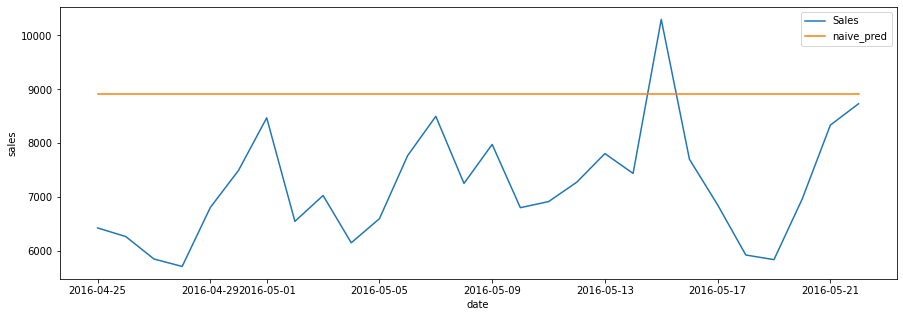

In [ ]:
def plot_pred(prediction_test_df, series_id, yhat):
  """
  Plot of predictions against actual sales for a specified time series
  """
  prediction_test_df_series = prediction_test_df.loc[prediction_test_df.series_id==series_id,:]
  plt.figure(figsize=(15,5))
  sns.lineplot(x=prediction_test_df_series.date, y=prediction_test_df_series.sales, label='Sales')
  sns.lineplot(x=prediction_test_df_series.date, y=prediction_test_df_series[yhat], label=yhat)

plot_pred(naive_test_df, 'TX_2_FOODS', 'naive_pred')

From our plot, we can see that the Naive predictions are uninteresting; just a horizontal straight line of constant value.

Let's impliment the seasonal Naive method (sesonality = 7 for our data)

### Seasonal naive forecast

In [ ]:
def snaive_predictions(training_df, test_df):
  """
  Returns dataframe with test data and corresponding predictions
  """
  training_df['dayofweek'] = training_df['date'].dt.weekday
  series_list = training_df['series_id'].unique()
  snaive_pred_list = []
  for series in series_list:
      training_df_series = training_df.loc[training_df.series_id==series,:]
      training_df_series.sort_values(by='date', ascending=False, inplace=True)
      last_week_df = training_df_series[:7][['dayofweek', 'series_id','sales']]
      snaive_pred_list.append(last_week_df)
  snaive_pred_df = pd.concat(snaive_pred_list)
  snaive_pred_df.rename(columns={'sales':'snaive_pred'}, inplace=True)
  test_df['dayofweek'] = test_df['date'].dt.weekday
  snaive_test_df = test_df.merge(snaive_pred_df, on=['series_id', 'dayofweek'], how='left')
  return snaive_test_df

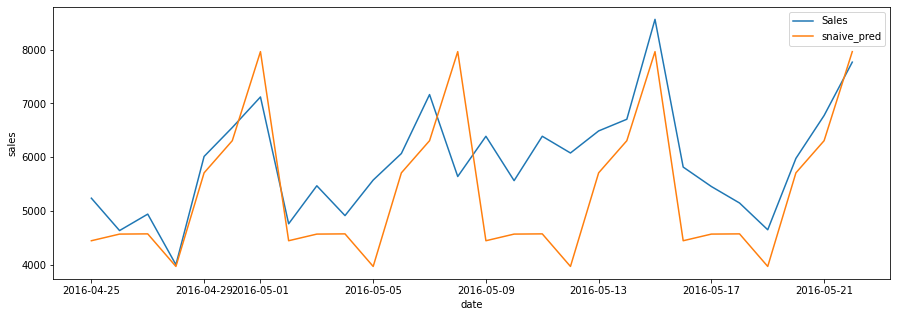

In [ ]:
snaive_test_df = snaive_predictions(training_df, test_df)
plot_pred(snaive_test_df, 'TX_1_FOODS', 'snaive_pred')

**Seasonal naive is a much better fit and should be the baseline**

## Evaluation metric : MAPE and WMPAE

We will use WMAPE as the evaluation metric. WMPAE - Weighted MAPE which is weighted by the sales in last 28 days of a time series. 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

def compute_mape(training_df, prediction_test_df, y, y_hat, series_id):
  """
  Given a time series ID, compute the MAPE for that time series and return the last 28-day training sales
  """
  training_df_series = training_df.loc[training_df.series_id==series_id,:]
  training_df_series.sort_values(by='date', ascending=False, inplace=True)
  total_sales = training_df_series[:28]['sales'].sum()
  mape = mean_absolute_percentage_error(prediction_test_df[y],prediction_test_df[y_hat])
  return mape,total_sales

def compute_wmape(training_df, prediction_test_df, y, y_hat):
  """
  Given a training and prediction data, compute the weighted MAPE
  """
  series_list = prediction_test_df.series_id.unique()
  sales_list = []
  mape_list = []
  for series in series_list:
    mape_series, total_sales_series = compute_mape(training_df, prediction_test_df, y, y_hat, series)
    mape_list.append(mape_series)
    sales_list.append(total_sales_series)
  overall_sales = np.sum(sales_list)
  weights_list = [s/overall_sales for s in sales_list]
  wmape_list = [a*b for a,b in zip(mape_list, weights_list)]
  wmape = np.sum(wmape_list)
  return wmape

In [ ]:
compute_wmape(training_df, snaive_test_df, 'sales', 'snaive_pred')

0.14506851477407343

## Prophet

In [ ]:
def prophet_predictions(training_df, test_df, monthly_seasonality=True, changepoint_prior_scale=0.05, changepoint_range=0.8):
  """
  Train and predict sales using Prophet
  """
  training_df.rename(columns={'sales': 'y', 'date':'ds'}, inplace=True)
  series_list = training_df['series_id'].unique()
  prophet_pred_list = []
  for series in tqdm(series_list, desc=f"Predicting:"):
      training_df_series = training_df.loc[training_df.series_id==series]
      m = Prophet(yearly_seasonality=False, daily_seasonality=False, 
                  changepoint_prior_scale=changepoint_prior_scale, changepoint_range=changepoint_range)
      if monthly_seasonality:
          # add monthly seasonality to model
          m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
      m.fit(training_df_series)
      future = m.make_future_dataframe(periods=28, include_history=False)
      forecast = m.predict(future)[['ds', 'yhat']]
      forecast['series_id'] = series
      prophet_pred_list.append(forecast)
  prophet_pred_df = pd.concat(prophet_pred_list)
  prophet_pred_df.rename(columns={'ds':'date', 'yhat':'prophet_pred'}, inplace=True)
  prophet_test_df = test_df.merge(prophet_pred_df, on=['series_id', 'date'], how='left')
  training_df.rename(columns={'ds': 'date', 'y': 'sales'}, inplace=True)
  return prophet_test_df

In [ ]:
# Run Prophet model for first CV split
# cv = 0
# training_df, validation_df, test_df = get_cv_split(sales_df, cv, validation=True)
prophet_test_df = prophet_predictions(training_df, validation_df)

Predicting:: 100%|██████████| 30/30 [01:09<00:00,  2.33s/it]


In [ ]:
prophet_test_df.info()
prophet_test_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store_id      840 non-null    object        
 1   cat_id        840 non-null    object        
 2   date          840 non-null    datetime64[ns]
 3   sales         840 non-null    float64       
 4   series_id     840 non-null    object        
 5   prophet_pred  840 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 45.9+ KB


,store_id,cat_id,date,sales,series_id,prophet_pred
0,TX_1,FOODS,2016-03-28,4761.47,TX_1_FOODS,4428.021532
1,TX_1,FOODS,2016-03-29,3878.09,TX_1_FOODS,3959.259688
2,TX_1,FOODS,2016-03-30,4161.50,TX_1_FOODS,3880.445561
3,TX_1,FOODS,2016-03-31,4082.22,TX_1_FOODS,3938.282849
4,TX_1,FOODS,2016-04-01,5269.88,TX_1_FOODS,4362.155605


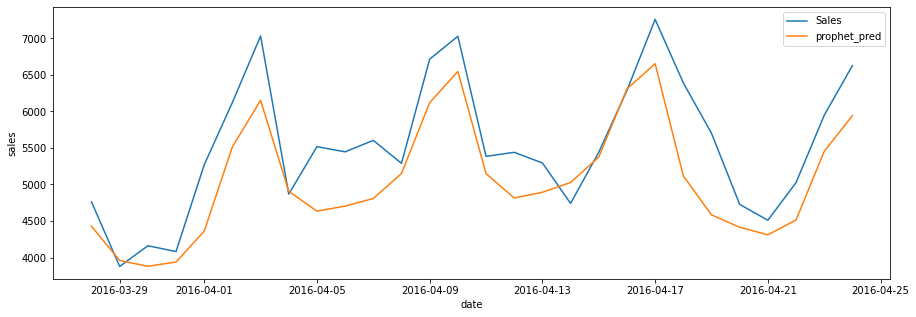

In [ ]:
# plot Prophet predictions against actual sales
plot_pred(prophet_test_df, 'TX_1_FOODS', 'prophet_pred')

### Hyperparameter Optimization : Prophet

In [ ]:
def grid_search_prophet():
    """
    Return optimal hyperparameters and weighted MAPE
    """
    param_grid = {  
    'changepoint_range': [0.8, 0.9],
    'changepoint_prior_scale': [0.05, 0.1, 0.3],
    }
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    best_result = np.inf
    best_params = None

    for param_set in all_params:
        print(f"Evaluating {param_set}...")
        wmae_list = []
        prophet_eval_df = prophet_predictions(training_df, validation_df, **param_set)
        wmape = compute_wmape(training_df, prophet_eval_df, 'sales', 'prophet_pred')

        print(f"Weighted MAPE for parameters {param_set} is: {wmape}")
        if wmape < best_result:
            best_params = param_set
            best_result = wmape
    print(f"Best eval result: {best_result} with parameters {best_params}")
    return best_result, best_params

In [ ]:
best_result, best_params = grid_search_prophet()

Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.05}...


Predicting:: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


Weighted MAPE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.05} is: 0.09763151848200086
Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.1}...


Predicting:: 100%|██████████| 30/30 [01:08<00:00,  2.30s/it]


Weighted MAPE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.1} is: 0.09722213732366673
Evaluating {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.3}...


Predicting:: 100%|██████████| 30/30 [01:30<00:00,  3.03s/it]


Weighted MAPE for parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.3} is: 0.0974716443568427
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.05}...


Predicting:: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


Weighted MAPE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.05} is: 0.09743464389337533
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.1}...


Predicting:: 100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


Weighted MAPE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.1} is: 0.09914899031479786
Evaluating {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.3}...


Predicting:: 100%|██████████| 30/30 [01:25<00:00,  2.85s/it]


Weighted MAPE for parameters {'changepoint_range': 0.9, 'changepoint_prior_scale': 0.3} is: 0.10142083768011129
Best eval result: 0.09722213732366673 with parameters {'changepoint_range': 0.8, 'changepoint_prior_scale': 0.1}


**MAPE using prophet is 0.097**